In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn

import torch
cuda = torch.cuda.is_available()
print("GPU:", cuda)

GPU: True


In [54]:
import os
import cv2  # OpenCV para leer imágenes

# Ruta de la carpeta del dataset
dataset_folder = 'F:\\PlantVillage-Dataset\\PlantVillage-Dataset\\raw\\grayscale'

# Lista de carpetas específicas que deseas cargar
carpetas_seleccionadas = [
    'Tomato___Septoria_leaf_spot',
    'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato___Target_Spot',
    'Tomato___Tomato_mosaic_virus',
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
    'Tomato___Bacterial_spot',
    'Tomato___Early_blight',
    'Tomato___healthy',
    'Tomato___Late_blight',
    'Tomato___Leaf_Mold'
]

# Lista para almacenar las matrices de las imágenes
imagenes = []

for carpeta in carpetas_seleccionadas:
    ruta_carpeta = os.path.join(dataset_folder, carpeta)
    
    if os.path.exists(ruta_carpeta) and os.path.isdir(ruta_carpeta):
        archivos_en_carpeta = os.listdir(ruta_carpeta)
        print(f"Archivos en {carpeta}: {len(archivos_en_carpeta)}")
        
        for archivo in archivos_en_carpeta:
            ruta_archivo = os.path.join(ruta_carpeta, archivo)
            
            # Leer la imagen usando OpenCV
            imagen = cv2.imread(ruta_archivo)
            imagenes.append(imagen)
    
    else:
        print(f"La carpeta {carpeta} no existe en el dataset.")

print("Total de archivos de imagen encontrados:", len(imagenes))

# las imágenes estan almacenadas en la lista "imagenes".




Archivos en Tomato___Septoria_leaf_spot: 1771
Archivos en Tomato___Spider_mites Two-spotted_spider_mite: 1676
Archivos en Tomato___Target_Spot: 1404
Archivos en Tomato___Tomato_mosaic_virus: 373
Archivos en Tomato___Tomato_Yellow_Leaf_Curl_Virus: 5357
Archivos en Tomato___Bacterial_spot: 2127
Archivos en Tomato___Early_blight: 1000
Archivos en Tomato___healthy: 1591
Archivos en Tomato___Late_blight: 1909
Archivos en Tomato___Leaf_Mold: 952
Total de archivos de imagen encontrados: 18160


In [51]:
imagenes.head()

,ruta,clase
0,F:\PlantVillage-Dataset\PlantVillage-Dataset\r...,Tomato___Septoria_leaf_spot
1,F:\PlantVillage-Dataset\PlantVillage-Dataset\r...,Tomato___Septoria_leaf_spot
2,F:\PlantVillage-Dataset\PlantVillage-Dataset\r...,Tomato___Septoria_leaf_spot
3,F:\PlantVillage-Dataset\PlantVillage-Dataset\r...,Tomato___Septoria_leaf_spot
4,F:\PlantVillage-Dataset\PlantVillage-Dataset\r...,Tomato___Septoria_leaf_spot


In [53]:
#Splitting train dataset into X and Y.Normalizing it by dividing it with 255

X = train.iloc[:,1:].values / 255
Y = train.iloc[:,0].values

AttributeError: 'list' object has no attribute 'iloc'

In [42]:
#visulaizing numbers in our dataset.
r = 4
c = 6
fig=plt.figure(figsize=(r, c),dpi=100)
for i in range(1, r*c+1):
    #AQUI VAMOS A DEFINIR EL TAMAÑO DE LAS IMAGENES.
    img = X[i].reshape(256,256)
    ax = fig.add_subplot(r, c, i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(Y[i])

    plt.imshow(img,cmap='gray')
plt.show()

NameError: name 'X' is not defined

<Figure size 400x600 with 0 Axes>

In [ ]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.2)

In [ ]:
#converting our data into a datloader object.

trn_x = torch.from_numpy(trn_x).type(torch.FloatTensor)
trn_y = torch.from_numpy(trn_y).type(torch.LongTensor)

val_x = torch.from_numpy(val_x).type(torch.FloatTensor)
val_y = torch.from_numpy(val_y).type(torch.LongTensor)

In [ ]:
from torch.utils.data import TensorDataset,DataLoader

trn = TensorDataset(trn_x,trn_y)
val = TensorDataset(val_x,val_y)

trn = DataLoader(trn,batch_size=1000)
val = DataLoader(val,batch_size=1000)

In [ ]:
shape = trn_x[0].shape
shape

torch.Size([784])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(65536,512)#esta es la entrada de la red neuronal
        self.linear2 = nn.Linear(512,256)
        self.linear3 = nn.Linear(256,10)

    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)

mlp = Model()

if cuda:
    mlp.cuda()

print(mlp)

Model(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
#define our optimizer
from torch.optim import Adam

optimizer = Adam(mlp.parameters(), lr=1e-3)

In [ ]:
def compute_val_loss(val_x,val_y,model):
    if cuda:
        val_x,val_y = val_x.cuda(),val_y.cuda()
    output = model(val_x)
    loss = F.cross_entropy(output,val_y)
    return loss

In [ ]:
EPOCHS = 2

trn_loss = []
val_loss = []

mlp.train()

for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(trn):

        if cuda:
            data,target = data.cuda(),target.cuda()

        optimizer.zero_grad()

        y_pred = mlp(data)

        loss = F.cross_entropy(y_pred, target)
        trn_loss.append(loss.cpu().data.item())

        loss.backward()
        optimizer.step()

        loss = compute_val_loss(val_x,val_y,mlp)
        val_loss.append(loss.cpu().data.item())

    print("Epoch: {} | loss: {} | val_loss: {}".format(epoch+1,trn_loss[-1],val_loss[-1]))

Epoch: 1 | loss: 0.35565581917762756 | val_loss: 0.3581877052783966
Epoch: 2 | loss: 0.25579801201820374 | val_loss: 0.26609671115875244
Epoch: 3 | loss: 0.2067803293466568 | val_loss: 0.22754785418510437
Epoch: 4 | loss: 0.170864537358284 | val_loss: 0.1973186582326889
Epoch: 5 | loss: 0.148243710398674 | val_loss: 0.17556650936603546
Epoch: 6 | loss: 0.1292995661497116 | val_loss: 0.1588653326034546
Epoch: 7 | loss: 0.1130184680223465 | val_loss: 0.14535991847515106
Epoch: 8 | loss: 0.09896637499332428 | val_loss: 0.13379305601119995
Epoch: 9 | loss: 0.08698887377977371 | val_loss: 0.12423226982355118
Epoch: 10 | loss: 0.07717505842447281 | val_loss: 0.11576734483242035


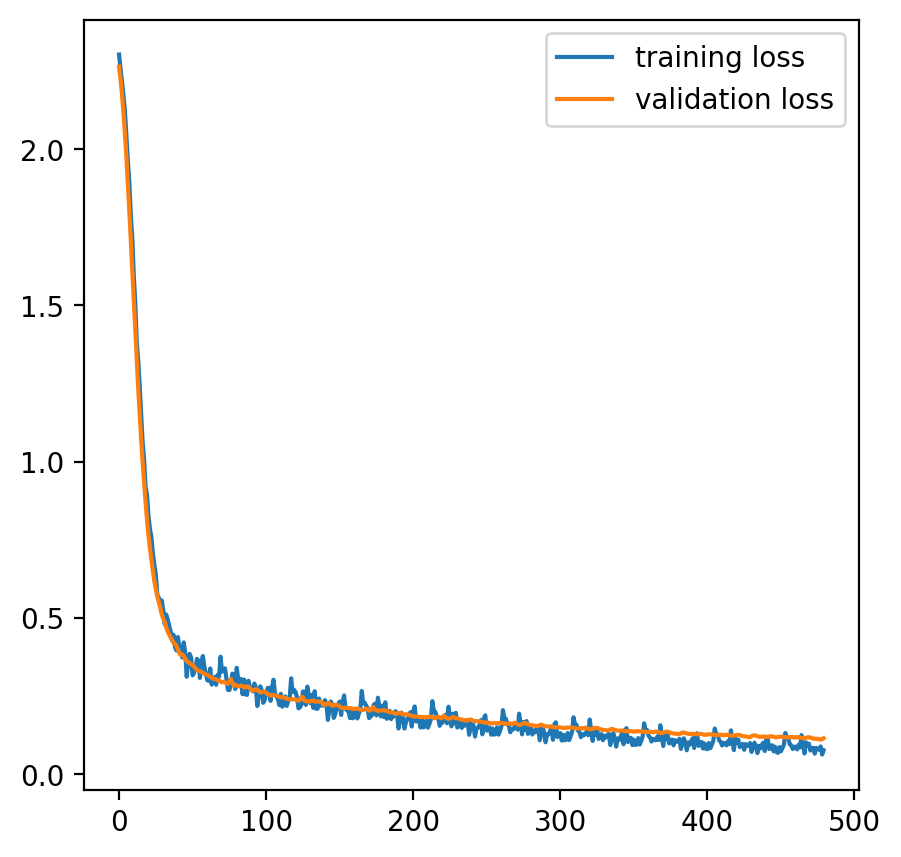

In [ ]:
plt.figure(figsize=(5,5),dpi=200)
plt.plot(trn_loss,label='training loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='upper right')

In [ ]:
def predict_with_pytorch(model,val_x):

    y_preds = []

    if cuda:
        val_x = val_x.cuda()

    out = model(val_x)
    _, predicted = torch.max(out.data,1)

    for p in predicted:
        y_preds.append(p.detach().cpu().numpy().item())


    return y_preds

In [ ]:
#predicting validation set and plotting a heatmap.

pred = predict_with_pytorch(mlp,val_x)

In [ ]:
val_x.numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val_y.numpy(),pred)

<Axes: >

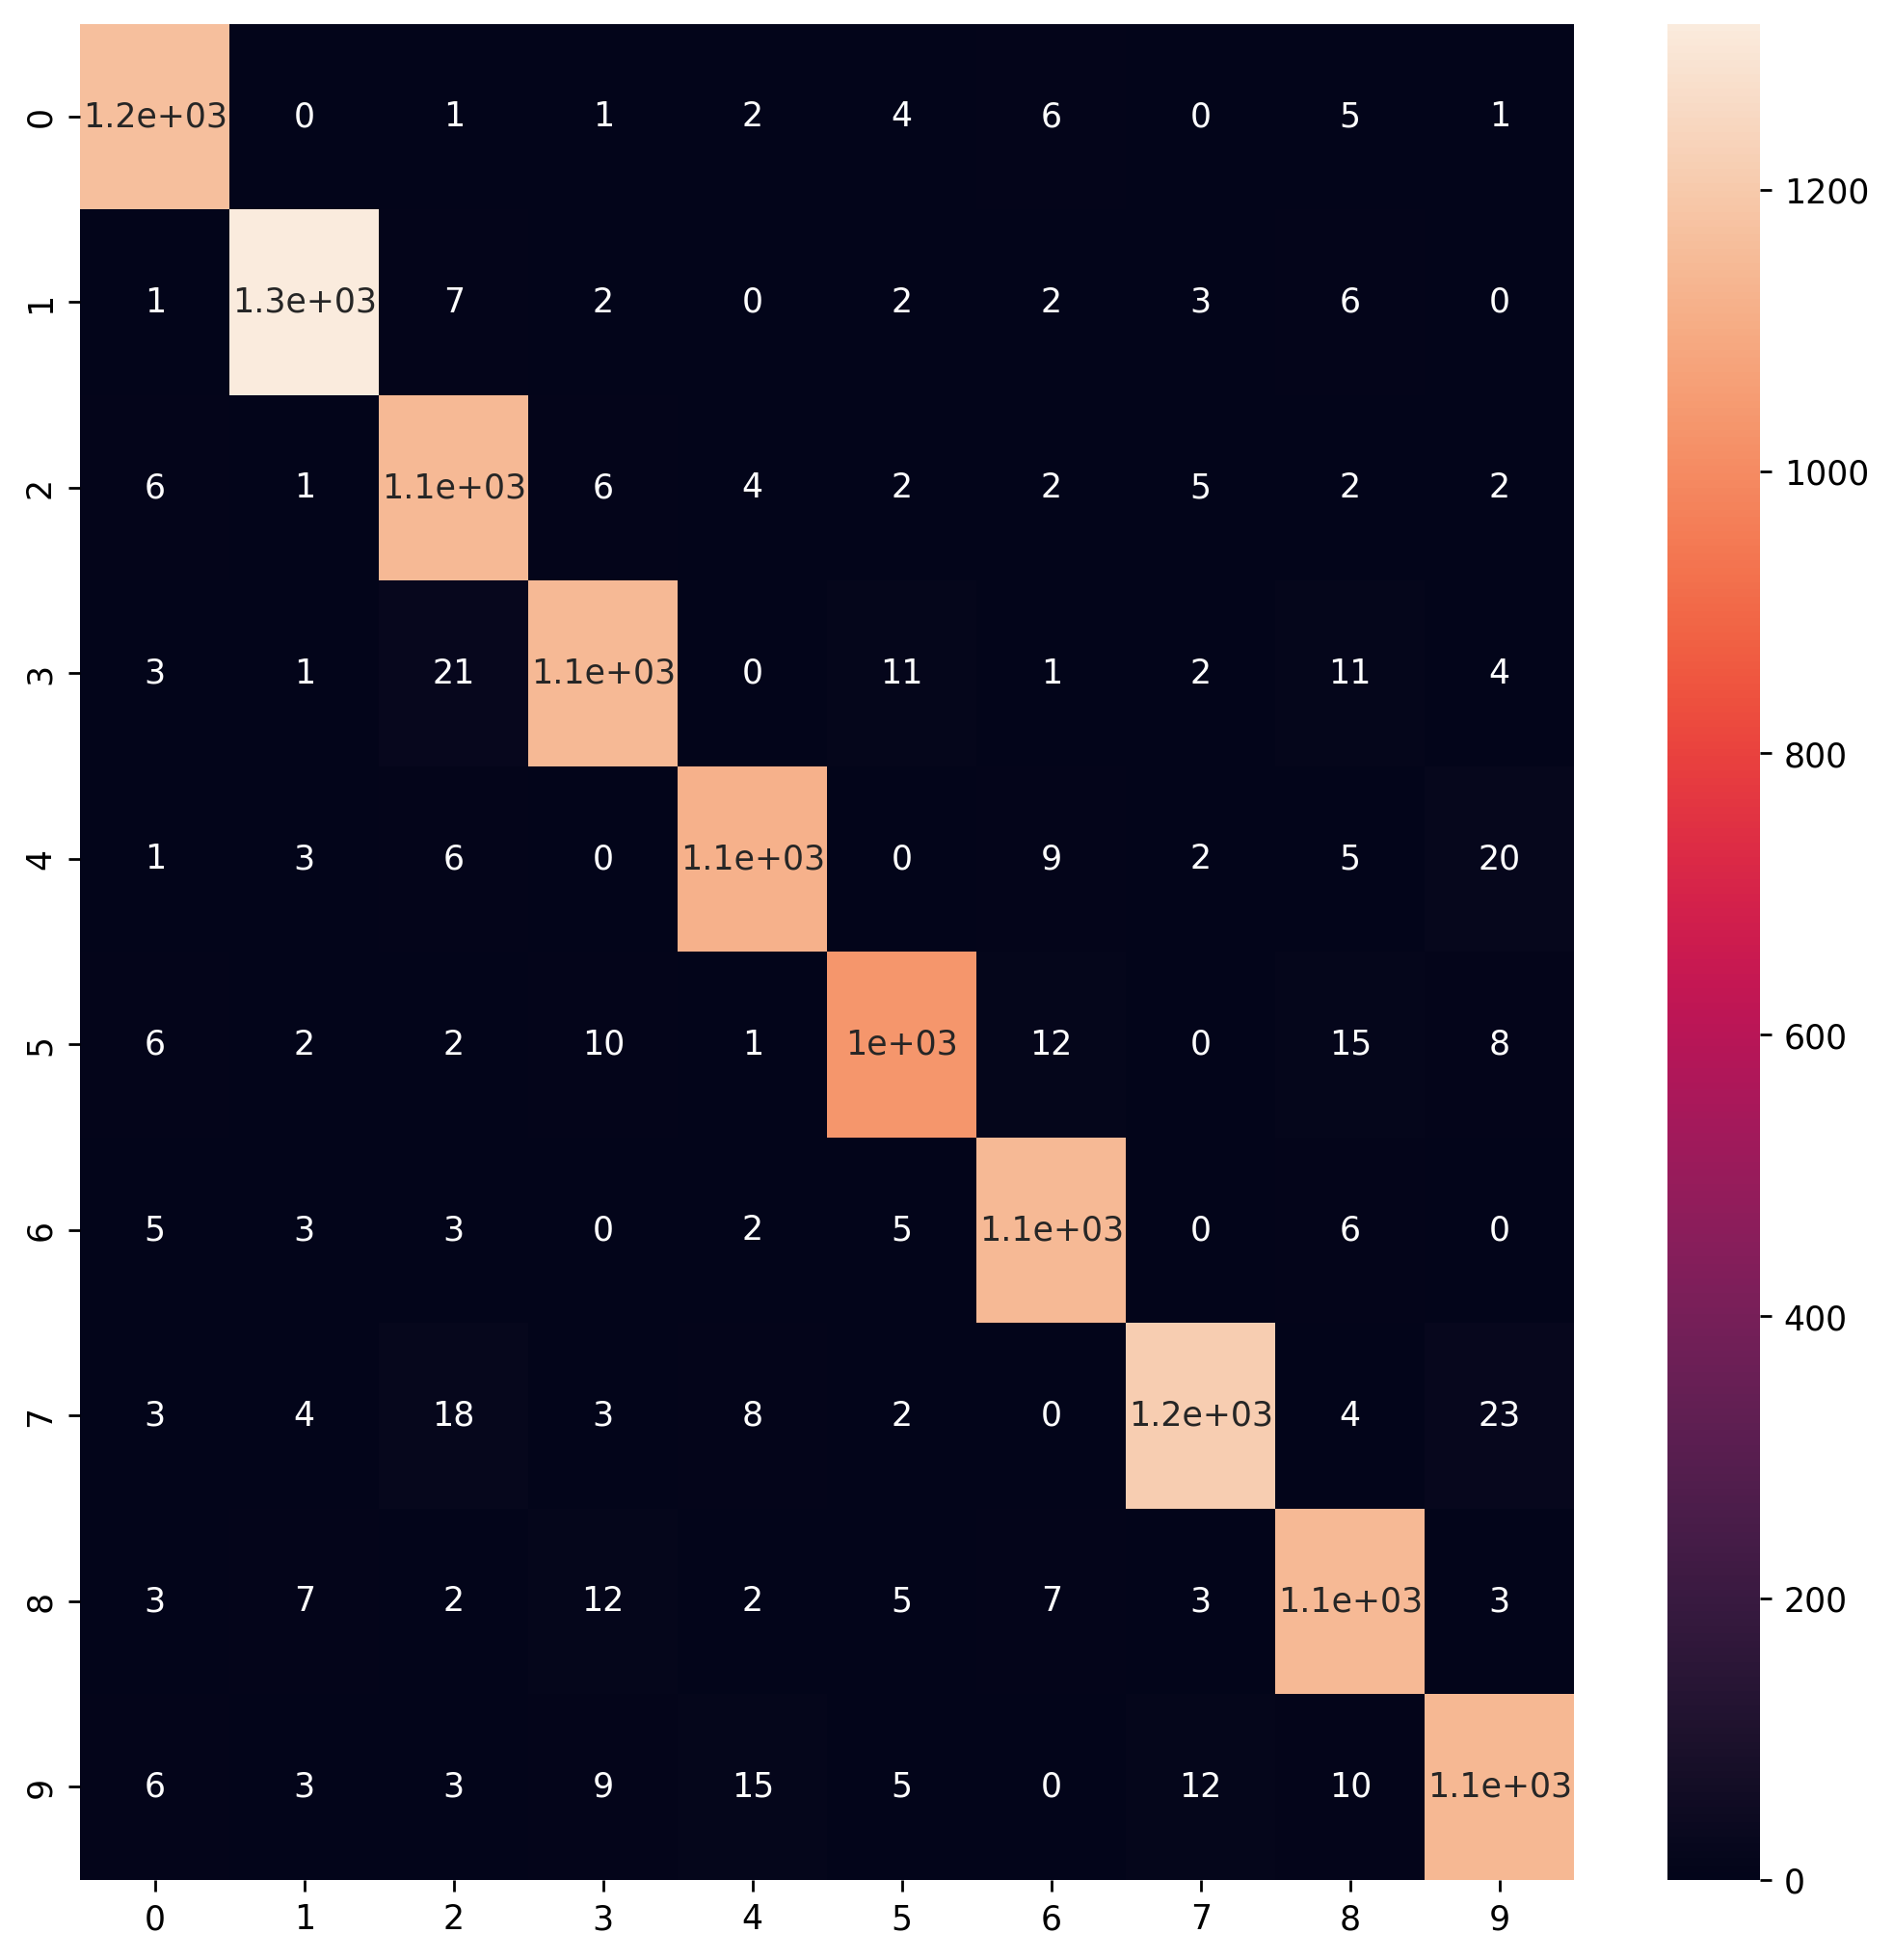

In [ ]:
plt.figure(figsize = (10,10),dpi=250)
seaborn.heatmap(cm,annot=True)

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(val_y.numpy(),pred)

print("Accuracy:",acc*100,"%")

Accuracy: 96.45833333333333 %
